=== 2025-11-25 ===
Rotas: 2 | Veículos usados: 2 | Distância total: 275.3 km
- Rota 0: veículo=Pequeno_1, paradas=3, dist=51.6 km, carga=0.93 m3 / 586 kg
- Rota 1: veículo=Grande_1, paradas=32, dist=223.7 km, carga=9.40 m3 / 5972 kg
Janelas violadas: 18


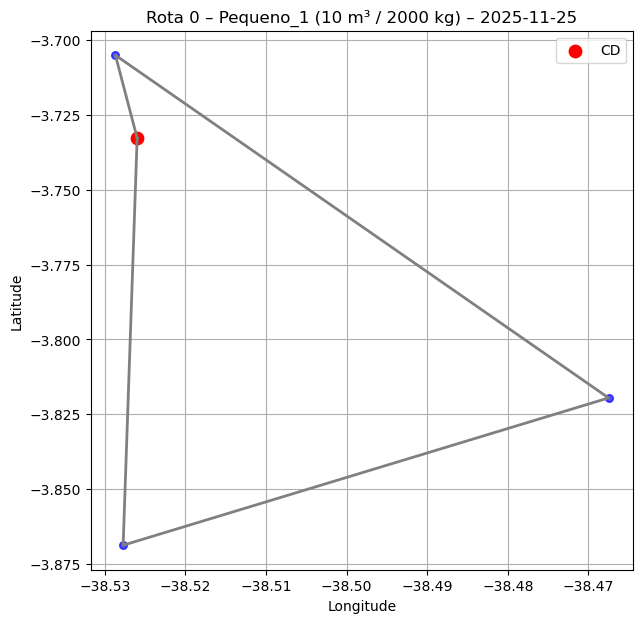

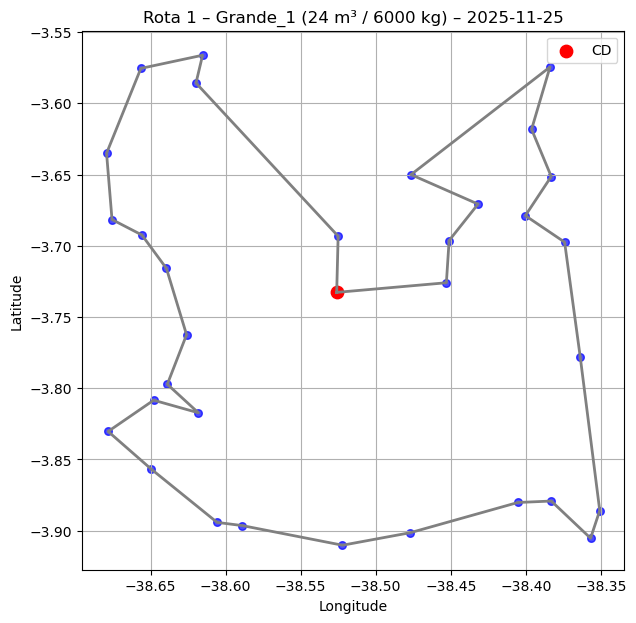

=== 2025-11-26 ===
Rotas: 2 | Veículos usados: 2 | Distância total: 268.8 km
- Rota 0: veículo=Medio_1, paradas=14, dist=81.6 km, carga=4.17 m3 / 2658 kg
- Rota 1: veículo=Grande_1, paradas=26, dist=187.1 km, carga=7.52 m3 / 4783 kg
Janelas violadas: 11


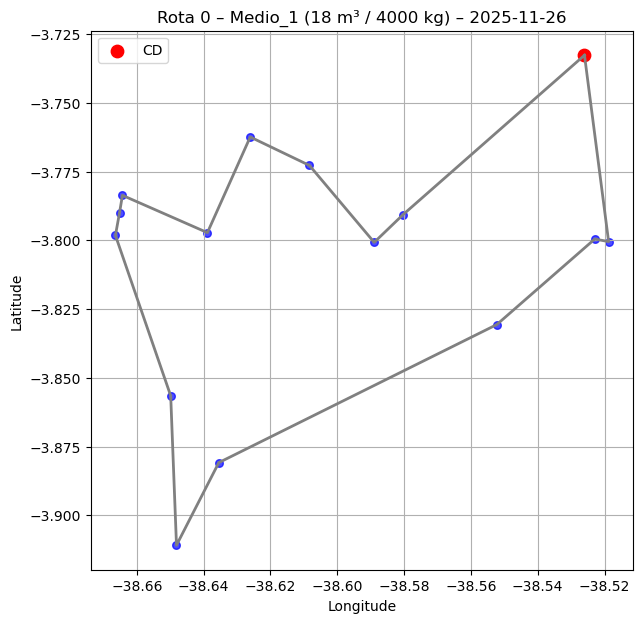

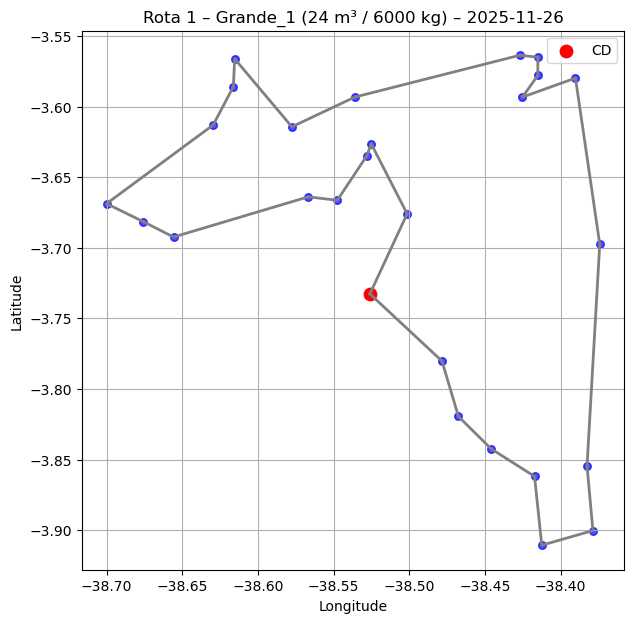

=== 2025-11-27 ===
Rotas: 2 | Veículos usados: 2 | Distância total: 318.4 km
- Rota 0: veículo=Grande_1, paradas=31, dist=205.2 km, carga=9.39 m3 / 5947 kg
- Rota 1: veículo=Grande_2, paradas=25, dist=113.2 km, carga=7.35 m3 / 4614 kg
Janelas violadas: 19


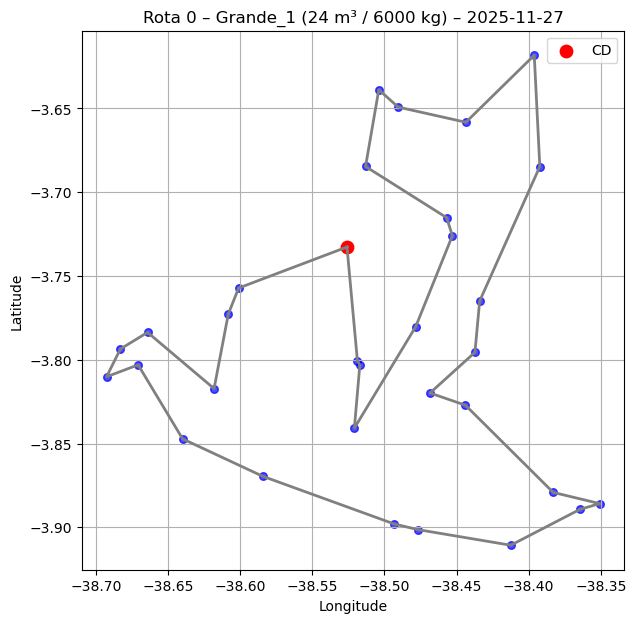

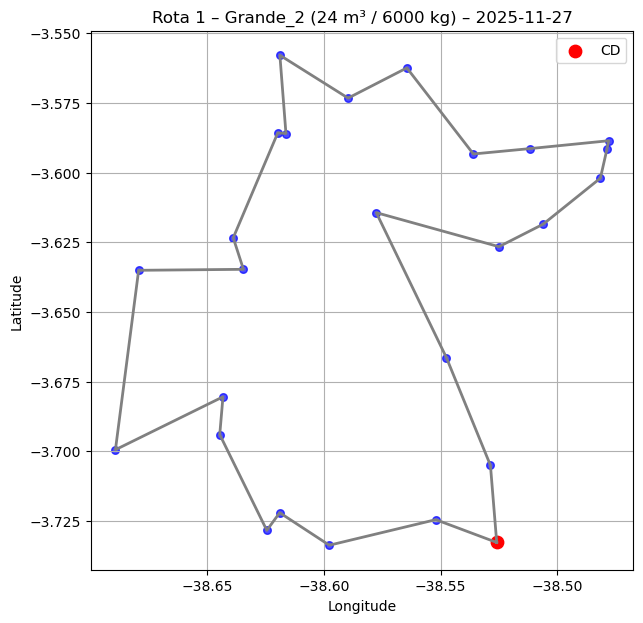

=== 2025-11-28 ===
Rotas: 2 | Veículos usados: 2 | Distância total: 282.6 km
- Rota 0: veículo=Grande_1, paradas=33, dist=242.7 km, carga=9.46 m3 / 5933 kg
- Rota 1: veículo=Pequeno_1, paradas=4, dist=39.9 km, carga=1.19 m3 / 755 kg
Janelas violadas: 17


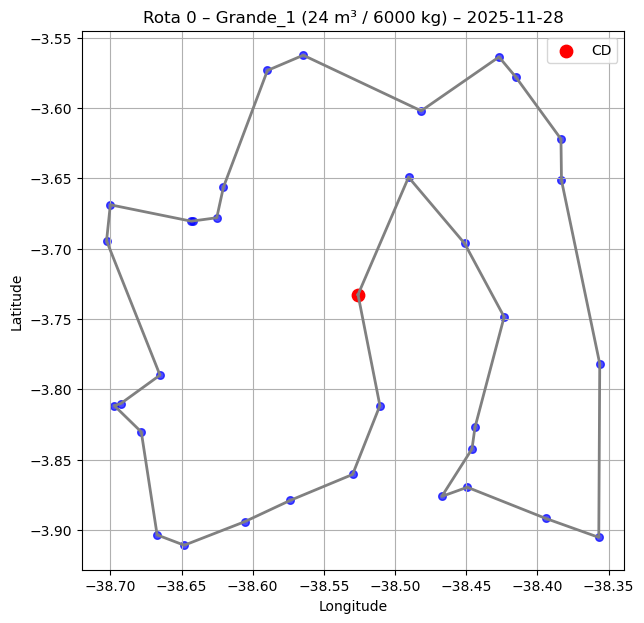

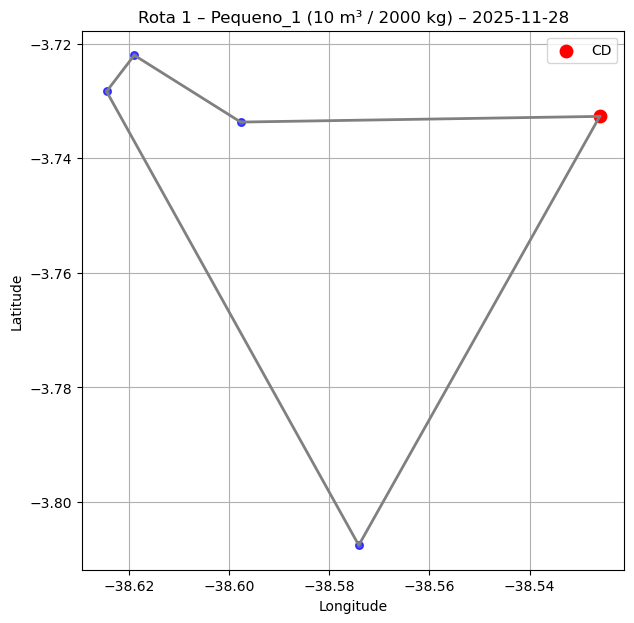

=== 2025-11-26 ===
Rotas: 2 | Veículos usados: 2 | Distância total: 268.8 km
- Rota 0: veículo=Medio_1, paradas=14, dist=81.6 km, carga=4.17 m3 / 2658 kg
- Rota 1: veículo=Grande_1, paradas=26, dist=187.1 km, carga=7.52 m3 / 4783 kg
Janelas violadas: 11
=== 2025-11-27 ===
Rotas: 2 | Veículos usados: 2 | Distância total: 318.6 km
- Rota 0: veículo=Grande_1, paradas=31, dist=205.2 km, carga=9.39 m3 / 5947 kg
- Rota 1: veículo=Grande_2, paradas=26, dist=113.4 km, carga=7.50 m3 / 4705 kg
Janelas violadas: 20


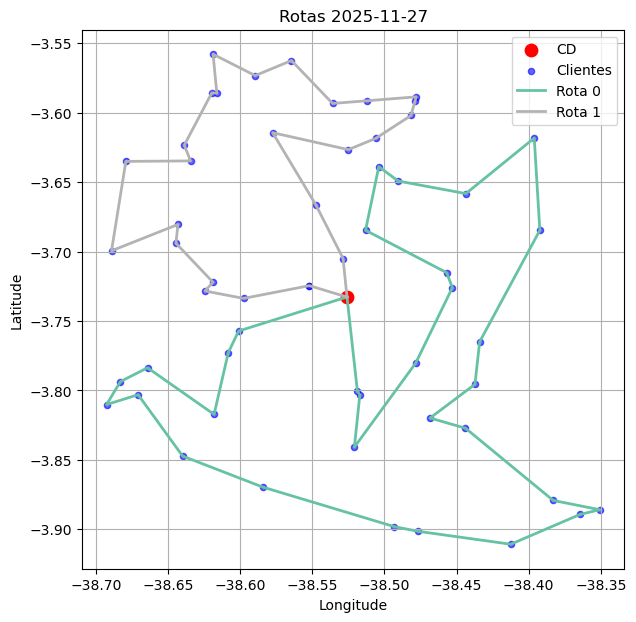

In [14]:
# 🚚 Sistema de Roteirização de Entregas (25–28/11/2025)

#Este notebook simula um sistema de roteirização ágil para entregas de refrigerantes,
#considerando capacidade dos veículos, cubagem, janelas de atendimento e geolocalização.

#O objetivo é:
#- Planejar rotas diárias (D+1) para os dias 25 a 28/11/2025
#- Respeitar capacidade volumétrica e de peso dos veículos
#- Considerar janelas de atendimento dos clientes
#- Minimizar distância total percorrida


## 1. Configuração inicial e geração de dados
#Nesta seção definimos:
#- Frota de veículos e suas capacidades
#- Catálogo de produtos (SKUs)
#- Clientes fictícios com coordenadas e janelas de recebimento
#- Funções auxiliares para cálculo de distância (Haversine)
# Imports e setup

import math, random, datetime as dt
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, List

random.seed(42); np.random.seed(42)

# Datas alvo
DATES = pd.to_datetime(["2025-11-25","2025-11-26","2025-11-27","2025-11-28"])

# Centro de distribuição (CD)
DEPOT = {"id":"CD","lat":-3.7327,"lon":-38.5260}

# Frota
@dataclass
class VehicleType:
    name:str; vol_m3:float; weight_kg:float

FLEET = [
    VehicleType("Pequeno_1",10,2000), VehicleType("Pequeno_2",10,2000),
    VehicleType("Medio_1",18,4000), VehicleType("Medio_2",18,4000),
    VehicleType("Grande_1",24,6000), VehicleType("Grande_2",24,6000)
]

# Catálogo de SKUs
CATALOG = pd.DataFrame([
    {"sku":"PET_2L","unit_volume_m3":0.003,"unit_weight_kg":2.2},
    {"sku":"Caixa_12x1L","unit_volume_m3":0.018,"unit_weight_kg":13.2},
    {"sku":"Bombona_20L","unit_volume_m3":0.035,"unit_weight_kg":21.5}
])

# Parâmetros operacionais
STACKING_EFFICIENCY=0.9; SERVICE_MINUTES=10
URBAN_SPEED_KMH=25; STREET_FACTOR=1.25
WORK_START=dt.time(8,0); WORK_END=dt.time(17,0)


## 2. Geração de clientes e pedidos
#Aqui criamos:
#- Clientes fictícios (~120) com coordenadas próximas a Fortaleza
#- Dias preferidos de recebimento (Ter–Sex)
#- Janelas de horário de atendimento
#- Pedidos simulados para cada dia, com quantidades aleatórias de SKUs
# Funções auxiliares
def random_point_around_fortaleza(n):
    lat,lon=DEPOT["lat"],DEPOT["lon"]
    return [(lat+np.random.uniform(-0.18,0.18),lon+np.random.uniform(-0.18,0.18)) for _ in range(n)]

def random_receive_days():
    options=["Tue","Wed","Thu","Fri"]
    k=np.random.choice([1,2],p=[0.6,0.4])
    return sorted(list(np.random.choice(options,k,replace=False)))

def random_time_window():
    start=np.random.choice([8,9,10]); end=np.random.choice([15,16,17])
    if end<=start:end=start+6
    return dt.time(start,0),dt.time(end,0)

# Clientes
N_CLIENTS=120; coords=random_point_around_fortaleza(N_CLIENTS)
clients=[]
for i,(lat,lon) in enumerate(coords,1):
    tw_start,tw_end=random_time_window()
    clients.append({"client_id":f"C{i:03d}","name":f"Cliente_{i:03d}",
                    "lat":lat,"lon":lon,"preferred_days":random_receive_days(),
                    "tw_start":tw_start,"tw_end":tw_end})
CLIENTS=pd.DataFrame(clients)

# Pedidos
def generate_daily_orders(dates,clients_df,catalog):
    orders=[]
    for date in dates:
        dow=date.day_name()[:3]
        for _,row in clients_df.iterrows():
            if dow in row["preferred_days"]:
                sku_counts={"PET_2L":np.random.poisson(30),
                            "Caixa_12x1L":np.random.poisson(6),
                            "Bombona_20L":np.random.poisson(2)}
                if sum(sku_counts.values())==0:continue
                orders.append({"date":date,"client_id":row["client_id"],"sku_qty":sku_counts})
    return pd.DataFrame(orders)

ORDERS=generate_daily_orders(DATES,CLIENTS,CATALOG)


## 3. Preparação dos pedidos
#Calculamos:
#- Volume e peso de cada pedido
#- Validação de viabilidade (se cabe em pelo menos um veículo)
CAT={r["sku"]:r for _,r in CATALOG.iterrows()}
def order_volume_weight(sku_qty:Dict[str,int])->Tuple[float,float]:
    vol=sum(CAT[sku]["unit_volume_m3"]*qty for sku,qty in sku_qty.items())/STACKING_EFFICIENCY
    wt=sum(CAT[sku]["unit_weight_kg"]*qty for sku,qty in sku_qty.items())
    return vol,wt

def enrich_orders(orders_df,clients_df):
    df=orders_df.copy()
    df["volume_m3"]=df["sku_qty"].apply(lambda q:order_volume_weight(q)[0])
    df["weight_kg"]=df["sku_qty"].apply(lambda q:order_volume_weight(q)[1])
    return df.merge(clients_df[["client_id","lat","lon","tw_start","tw_end"]],on="client_id")

DAILY=enrich_orders(ORDERS,CLIENTS)
max_vol=max(v.vol_m3 for v in FLEET); max_wt=max(v.weight_kg for v in FLEET)
DAILY=DAILY[(DAILY["volume_m3"]<=max_vol)&(DAILY["weight_kg"]<=max_wt)]


## 4. Construção da matriz de custos
#Geramos matriz de distâncias e tempos entre CD e clientes do dia.
def haversine_km(lat1,lon1,lat2,lon2):
    R=6371;phi1,phi2=map(math.radians,[lat1,lat2])
    dphi=math.radians(lat2-lat1);dlambda=math.radians(lon2-lon1)
    a=math.sin(dphi/2)**2+math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return R*2*math.atan2(math.sqrt(a),math.sqrt(1-a))

def build_costs_for_day(day_df):
    nodes=[{"id":"CD","lat":DEPOT["lat"],"lon":DEPOT["lon"]}]
    for _,r in day_df.iterrows():nodes.append({"id":r["client_id"],"lat":r["lat"],"lon":r["lon"]})
    N=len(nodes);dist=np.zeros((N,N));time=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i==j:continue
            d=haversine_km(nodes[i]["lat"],nodes[i]["lon"],nodes[j]["lat"],nodes[j]["lon"])*STREET_FACTOR
            dist[i,j]=d;time[i,j]=d/URBAN_SPEED_KMH
    return nodes,dist,time


## 5. Heurística de roteirização
#Implementamos o algoritmo de Clarke-Wright Savings adaptado para considerar
#capacidade volumétrica e de peso dos veículos. Após gerar as rotas iniciais,
#aplicamos um refinamento simples (2-opt) para reduzir a distância total.

@dataclass
class Demand:
    vol: float
    wt: float
    tw_start: dt.time
    tw_end: dt.time
    service_h: float = SERVICE_MINUTES/60

def clarke_wright(day_df: pd.DataFrame, dist_km: np.ndarray, time_h: np.ndarray, vehicles: List[VehicleType]):
    # Nós: 0 = CD, 1..N-1 = clientes
    N = dist_km.shape[0]
    clients_idx = list(range(1, N))

    # Demandas por cliente
    demands: Dict[int, Demand] = {}
    for i, (_, r) in enumerate(day_df.iterrows(), start=1):
        demands[i] = Demand(r["volume_m3"], r["weight_kg"], r["tw_start"], r["tw_end"], SERVICE_MINUTES/60)

    # Inicial: uma rota CD-i-CD para cada cliente
    routes = [[0, i, 0] for i in clients_idx]
    route_loads = {i: (demands[i].vol, demands[i].wt, demands[i].service_h) for i in clients_idx}

    # Savings s(i,j) = d(0,i)+d(0,j)-d(i,j)
    savings = []
    for i in clients_idx:
        for j in clients_idx:
            if i < j:
                s = dist_km[0,i] + dist_km[0,j] - dist_km[i,j]
                savings.append((s, i, j))
    savings.sort(reverse=True, key=lambda x: x[0])

    # Capacidade máxima (maior veículo)
    max_vol = max(v.vol_m3 for v in vehicles)
    max_wt = max(v.weight_kg for v in vehicles)

    # Mapa de rotas
    node2route = {i: k for k, i in enumerate(clients_idx)}
    route_cargo = {k: route_loads[route[1]] for k, route in enumerate(routes)}

    def route_ends(route):
        return route[1], route[-2]

    # Merge rotas com savings
    for s, i, j in savings:
        ri = node2route[i]; rj = node2route[j]
        if ri == rj: continue
        route_i = routes[ri]; route_j = routes[rj]
        i_start, i_end = route_ends(route_i)
        j_start, j_end = route_ends(route_j)
        new_route = None
        if i_start == i and j_start == j:
            new_route = route_j[::-1][:-1] + route_i[1:]
        elif i_start == i and j_end == j:
            new_route = route_j[:-1] + route_i[1:]
        elif i_end == i and j_start == j:
            new_route = route_i[:-1] + route_j[1:]
        elif i_end == i and j_end == j:
            new_route = route_i[:-1] + route_j[::-1][1:]
        if new_route:
            vol_i, wt_i, svc_i = route_cargo[ri]
            vol_j, wt_j, svc_j = route_cargo[rj]
            vol_new, wt_new, svc_new = vol_i+vol_j, wt_i+wt_j, svc_i+svc_j
            if vol_new <= max_vol and wt_new <= max_wt:
                routes[ri] = new_route
                route_cargo[ri] = (vol_new, wt_new, svc_new)
                for node in route_j[1:-1]:
                    node2route[node] = ri
                routes[rj] = []
                route_cargo[rj] = (0,0,0)

    # Limpar rotas vazias
    routes = [r for r in routes if r]

    # 2-opt simples
    def route_distance(route):
        return sum(dist_km[route[k], route[k+1]] for k in range(len(route)-1))
    def two_opt(route):
        best = route[:]
        for i in range(1, len(best)-2):
            for j in range(i+1, len(best)-1):
                if j-i == 1: continue
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                if route_distance(new_route) < route_distance(best):
                    best = new_route
        return best

    routes_opt = [two_opt(r) for r in routes]

    # Cargas finais
    route_cargo_final = []
    for r in routes_opt:
        vol = sum(demands[n].vol for n in r[1:-1])
        wt  = sum(demands[n].wt for n in r[1:-1])
        svc = sum(demands[n].service_h for n in r[1:-1])
        route_cargo_final.append((vol, wt, svc))

    return routes_opt, route_cargo_final

# Atribuição de veículos
def assign_vehicles_to_routes(routes, cargo, vehicles, dist_km):
    order = sorted(range(len(routes)), key=lambda k: cargo[k][0], reverse=True)
    available = vehicles[:]
    assignments = []
    for k in order:
        vol, wt, svc = cargo[k]
        feasible = [v for v in available if v.vol_m3 >= vol and v.weight_kg >= wt]
        if feasible:
            chosen = sorted(feasible, key=lambda v: (v.vol_m3, v.weight_kg))[0]
            assignments.append((k, chosen))
            available.remove(chosen)
        else:
            assignments.append((k, None))
    dists = [sum(dist_km[r[i], r[i+1]] for i in range(len(r)-1)) for r in routes]
    return assignments, dists


## 6. Execução por dia e relatório
#Nesta seção simulamos cada dia (25 a 28/11/2025), geramos as rotas com a heurística,
#atribuímos veículos e mostramos um resumo com distância total, número de rotas e
#eventuais violações de janelas de atendimento.

def simulate_day(date: pd.Timestamp, daily_df: pd.DataFrame):
    day_orders = daily_df[daily_df["date"] == date].reset_index(drop=True)
    if day_orders.empty:
        return {"date": date, "routes": [], "cargo": [], "assign": [], "dists": [], "nodes": [], "dist_km": None}

    # Construir matriz de custos
    nodes, dist_km, time_h = build_costs_for_day(day_orders)

    # Gerar rotas com Clarke-Wright + 2-opt
    routes, cargo = clarke_wright(day_orders, dist_km, time_h, FLEET)

    # Atribuir veículos
    assignments, dists = assign_vehicles_to_routes(routes, cargo, FLEET, dist_km)

    # Validação simples de janelas de tempo
    start_dt = dt.datetime.combine(date.date(), WORK_START)
    violations = []
    for idx_r, r in enumerate(routes):
        t = start_dt
        for node in r[1:-1]:  # clientes
            prev = r[r.index(node)-1]
            travel_h = time_h[prev, node]
            t += dt.timedelta(hours=travel_h)
            ord_row = day_orders.iloc[node-1]
            if not (ord_row["tw_start"] <= t.time() <= ord_row["tw_end"]):
                violations.append({
                    "route": idx_r,
                    "client_id": ord_row["client_id"],
                    "arrival": t.time(),
                    "tw": (ord_row["tw_start"], ord_row["tw_end"])
                })
            t += dt.timedelta(hours=SERVICE_MINUTES/60)

    return {
        "date": date,
        "routes": routes,
        "cargo": cargo,
        "assign": assignments,
        "dists": dists,
        "nodes": nodes,
        "dist_km": dist_km,
        "violations": violations,
        "orders": day_orders
    }

def daily_summary(result):
    date = result["date"]
    print(f"=== {date.date()} ===")
    total_dist = sum(result["dists"])
    used = sum(1 for _, v in result["assign"] if v is not None)
    print(f"Rotas: {len(result['routes'])} | Veículos usados: {used} | Distância total: {total_dist:.1f} km")
    for i, r in enumerate(result["routes"]):
        vol, wt, svc = result["cargo"][i]
        assign = [v for k,v in result["assign"] if k == i][0]
        vname = assign.name if assign else "SEM_VEICULO"
        dist = result["dists"][i]
        stops = len(r) - 2
        print(f"- Rota {i}: veículo={vname}, paradas={stops}, dist={dist:.1f} km, carga={vol:.2f} m3 / {wt:.0f} kg")
    if result["violations"]:
        print(f"Janelas violadas: {len(result['violations'])}")
    else:
        print("Sem violações de janela (simulação simples).")

def plot_routes_by_vehicle(result, figsize=(7,7)):
    if not result["routes"]:
        print("Sem rotas para o dia.")
        return
    
    day_orders = result["orders"]
    
    for i, r in enumerate(result["routes"]):
        plt.figure(figsize=figsize)
        
        # CD
        plt.scatter(DEPOT["lon"], DEPOT["lat"], c="red", s=80, label="CD")
        
        # Clientes da rota
        xs, ys = [], []
        for node in r:
            if node == 0:
                xs.append(DEPOT["lon"]); ys.append(DEPOT["lat"])
            else:
                row = day_orders.iloc[node-1]
                xs.append(row["lon"]); ys.append(row["lat"])
                plt.scatter(row["lon"], row["lat"], c="blue", s=30, alpha=0.7)
        
        # Linha da rota
        plt.plot(xs, ys, color="gray", linewidth=2)
        
        # Veículo atribuído
        assign = [v for k,v in result["assign"] if k == i][0]
        vname = assign.name if assign else "SEM_VEICULO"
        vvol = assign.vol_m3 if assign else "-"
        vwt  = assign.weight_kg if assign else "-"
        
        # Título completo
        plt.title(f"Rota {i} – {vname} ({vvol} m³ / {vwt} kg) – {result['date'].date()}")
        plt.xlabel("Longitude"); plt.ylabel("Latitude")
        plt.legend(loc="best"); plt.grid(True)
        plt.show()

# Executar para os quatro dias com visualização separada por rota
RESULTS = [simulate_day(d, DAILY) for d in DATES]
for res in RESULTS:
    daily_summary(res)
    plot_routes_by_vehicle(res)


    
## 7. Planejamento rolling (D+1)
#Nesta seção planejamos sempre o dia seguinte a partir de uma data corrente.
#Também simulamos a inclusão de pedidos de última hora e reotimizamos as rotas.
# Função para planejar sempre o "dia seguinte" dado um dia corrente
def plan_next_day(current_date: pd.Timestamp, daily_df: pd.DataFrame):
    idx = list(DATES).index(current_date)
    if idx >= len(DATES)-1:
        print("Não há dia seguinte dentro do período.")
        return None
    next_date = DATES[idx+1]
    res = simulate_day(next_date, daily_df)
    daily_summary(res)
    return res

# Exemplo: partindo do dia 25/11 para o dia 26/11
_ = plan_next_day(pd.to_datetime("2025-11-25"), DAILY)

# Função para adicionar pedido extra de última hora
def add_last_minute_order(date: pd.Timestamp, client_id: str, sku_qty: Dict[str,int], daily_df: pd.DataFrame):
    new = {"date": date, "client_id": client_id, "sku_qty": sku_qty}
    df = pd.concat([daily_df[["date","client_id","sku_qty"]], pd.DataFrame([new])], ignore_index=True)
    df = enrich_orders(df, CLIENTS)
    return df

# Exemplo: adicionar pedido extra para um cliente no dia 27/11 e replanejar
example_client = CLIENTS.sample(1, random_state=0)["client_id"].values[0]
DAILY_MOD = add_last_minute_order(pd.to_datetime("2025-11-27"), example_client,
                                  {"PET_2L": 20, "Caixa_12x1L": 2, "Bombona_20L": 1}, DAILY)

res_mod = simulate_day(pd.to_datetime("2025-11-27"), DAILY_MOD)
daily_summary(res_mod)
plot_day(res_mod, figsize=(7,7))
